# English Premier League Player Market Value Prediction
###  R
This project predicts the market value in millions of pounds of football players in the english premier league for the 2016/2017 season. This prediction is based on various factors. We will use both linear regression and random forest models for this task.

First off, we'll set our work directory to wherever our data is stored and load the libraries we might need! I've got a few handy ones down

In [5]:
setwd("C:/Users/rachi/Documents/UCLA/Predictive Analytics/Project")
library(tidyr)
library(DataExplorer)
library(ggplot2)
#library(caret)

Let's take a look at the dataset shall we:

In [6]:
## read dataset and view its properties
epl <- read.csv(file = "epldata_final.csv", header = TRUE)
dim(epl)
head(epl, n = 3)
#summary(epl)
#create_report(epl)

[1] 461  17

name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
Alexis Sanchez,Arsenal,28,LW,1,65,4329,12.0,17.10%,264,3,Chile,0,4,1,1,0
Mesut Ozil,Arsenal,28,AM,1,50,4395,9.5,5.60%,167,2,Germany,0,4,1,1,0
Petr Cech,Arsenal,35,GK,4,7,1529,5.5,5.90%,134,2,Czech Republic,0,6,1,1,0


We can see that the dataset has 461 rows and 17 features, and futher examination we can see that only one feature has missing values, so we have to perform some data manipulation. We also want to change some of the category value of some features for a better understanding. 
Position_cat from numericals to positonal names; Age_cat from numericals to age groups and we created a new dataset for all the big six clubs ('Arsenal, Chelsea, Liverpool, Man City, Man United and Tottenham')

In [7]:
## data manipulation ###
epl$region[epl$nationality =="Benin"] <- 4
epl$position_cat <- factor(epl$position_cat, levels = 1:4, labels = c("Attacker","Midfielder","Defender", "GoalKeeper"))
epl$age_cat <- factor(epl$age_cat, levels = 1:6, labels = c("17-21","22-25","26-28", "29-31","32-33","34-38"))

big_six <- subset(epl, epl$big_club == 1)

## Visual Data Exploration
We're going to be looking at various distributions in respect to the market value, focus is on the correlation between each feature and our target market value so we can select which features might be suitable to go into our model.

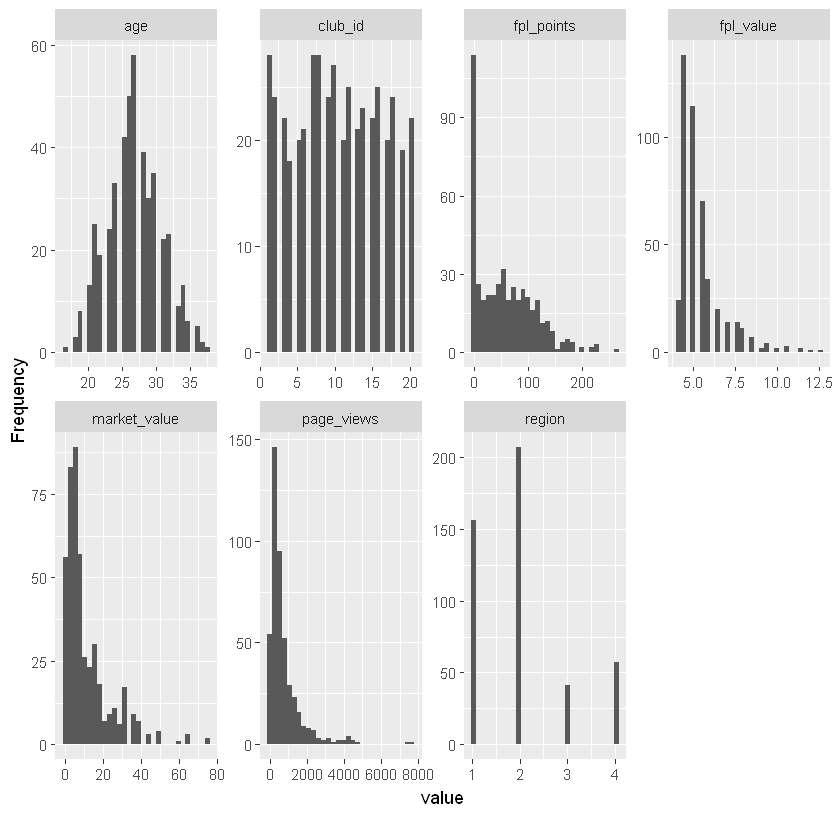

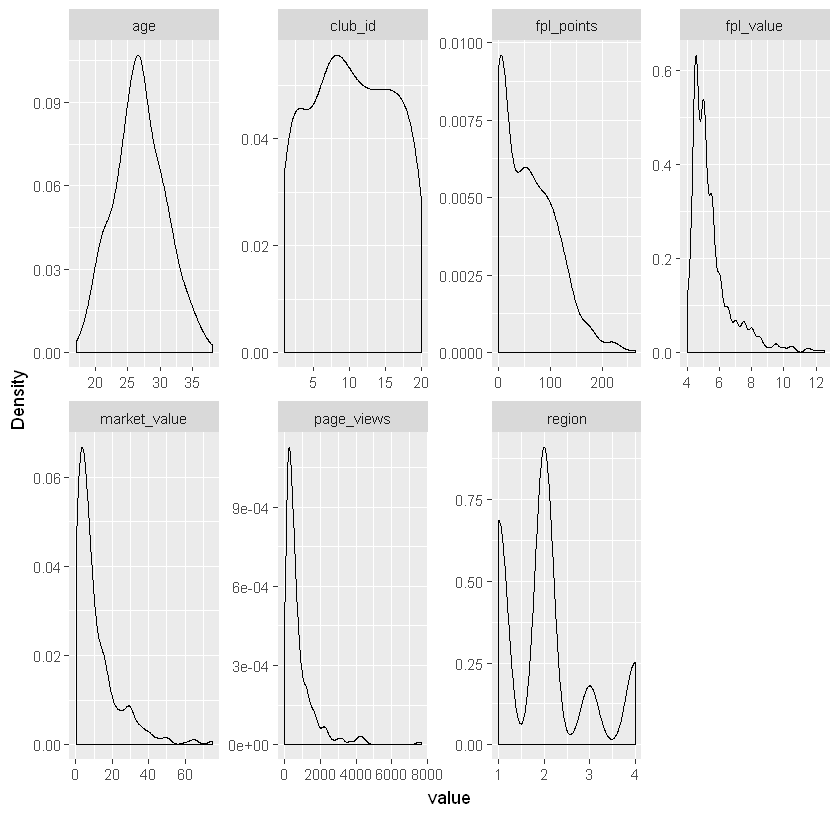

3 columns ignored with more than 50 categories.
name: 461 categories
fpl_sel: 113 categories
nationality: 61 categories



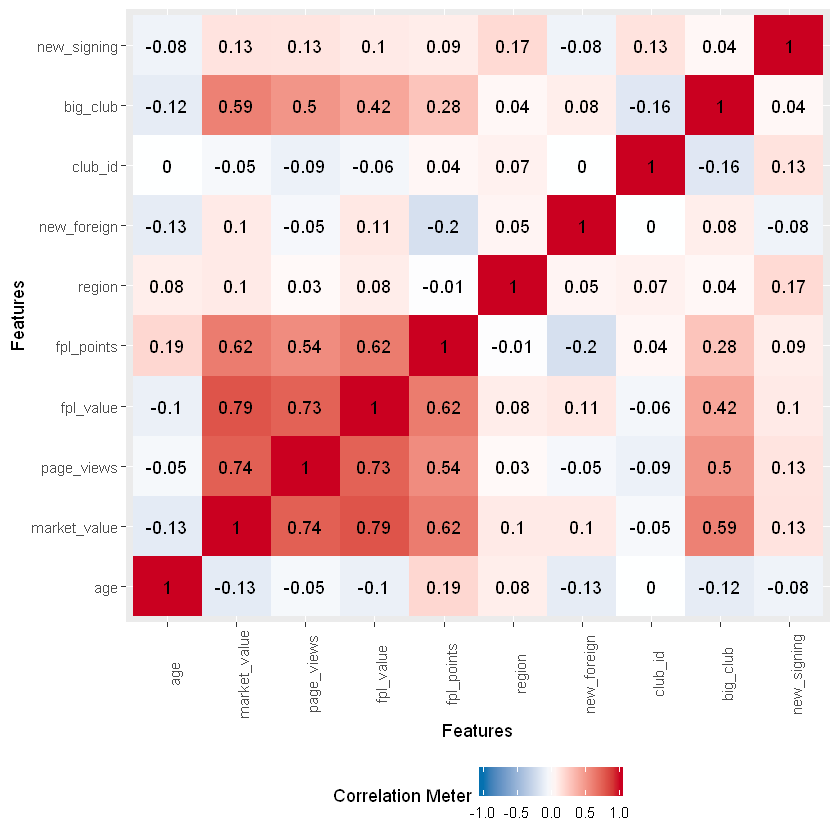

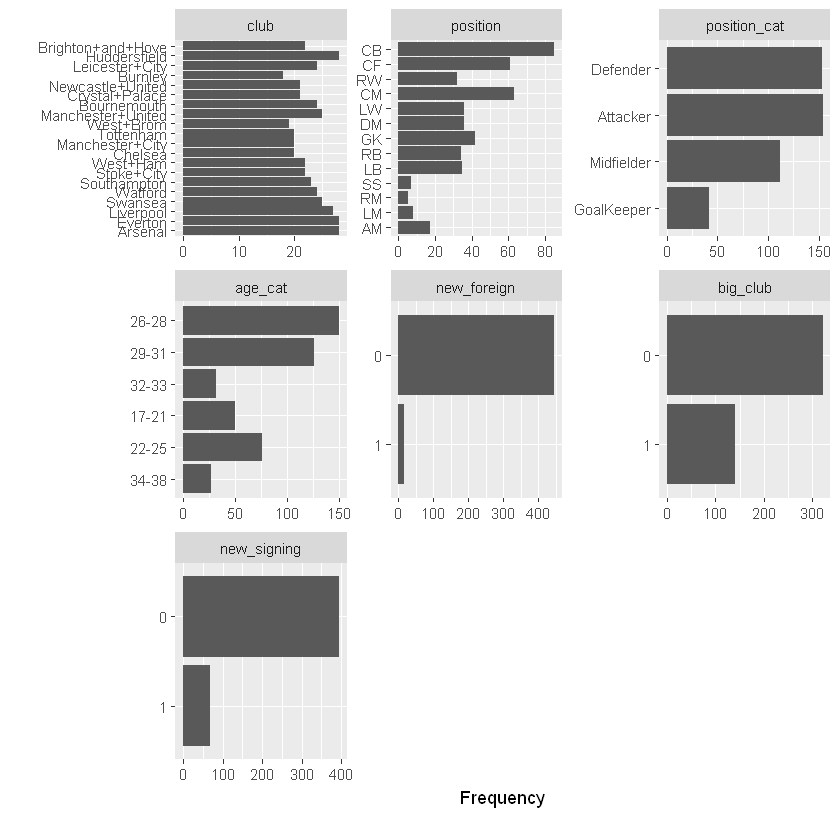

In [8]:
### Exploratory Data Analysis #####
#plot_str(epl)
plot_histogram(epl)
plot_density(epl)
plot_correlation(epl,"continuous")
plot_bar(epl) #cartegorical

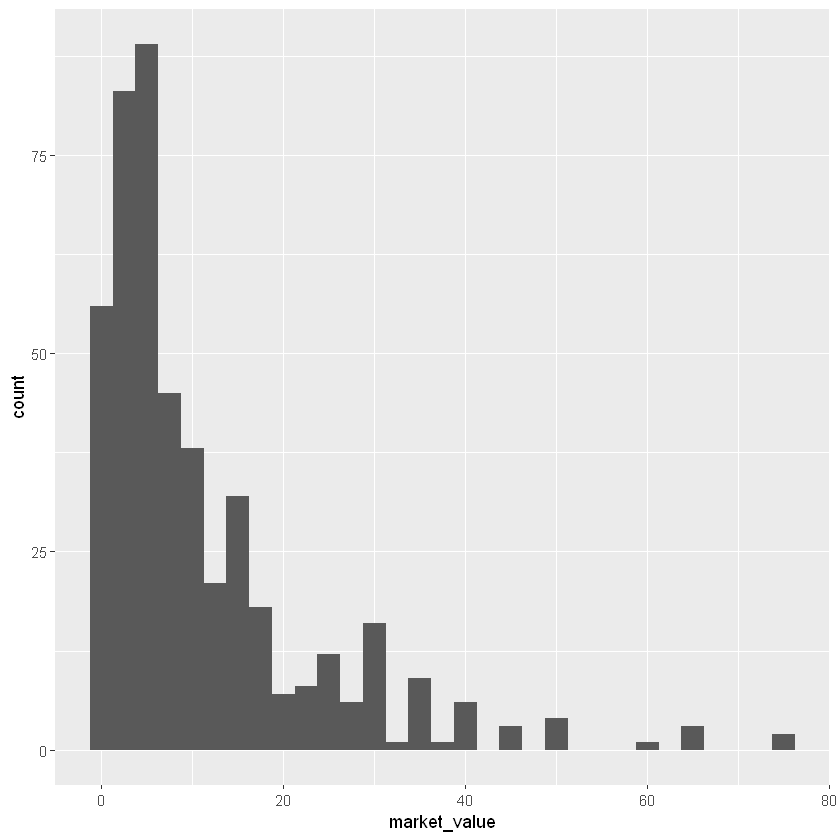

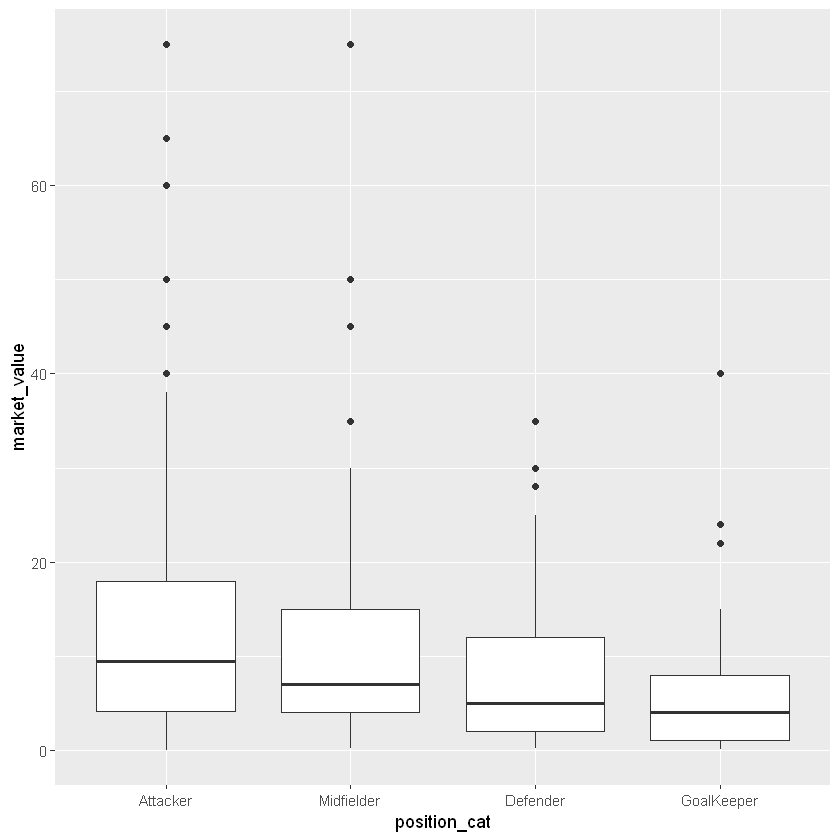

In [9]:
#we are focusing on market value lets check the distribution
ggplot(epl,aes(market_value))+geom_histogram(binwidth = 2.5)
ggplot(epl,(aes(x = position_cat, y = market_value)))+geom_boxplot() 

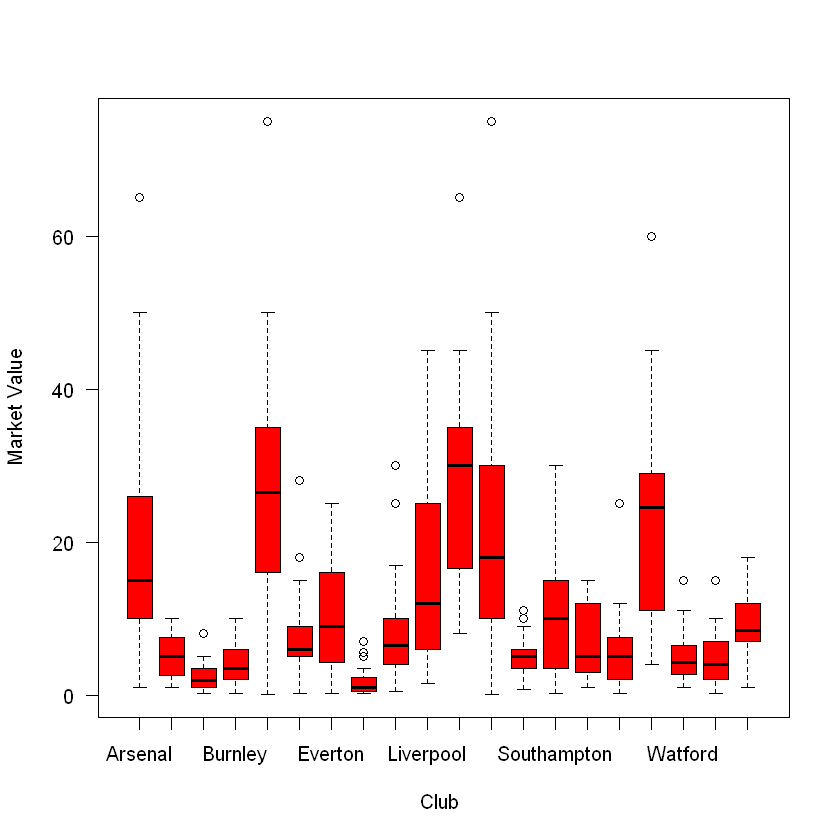

In [10]:
#market value by team
with(data=epl,plot(club, epl$market_value, 
                      xlab = "Club ", ylab = "Market Value", 
                      col = "red", las = 1))

The highest market values are found in the big six clubs, thats expected as are the three lowest being from the three newly promoted teams. Lets look at how page views (wikipidia) affects value.

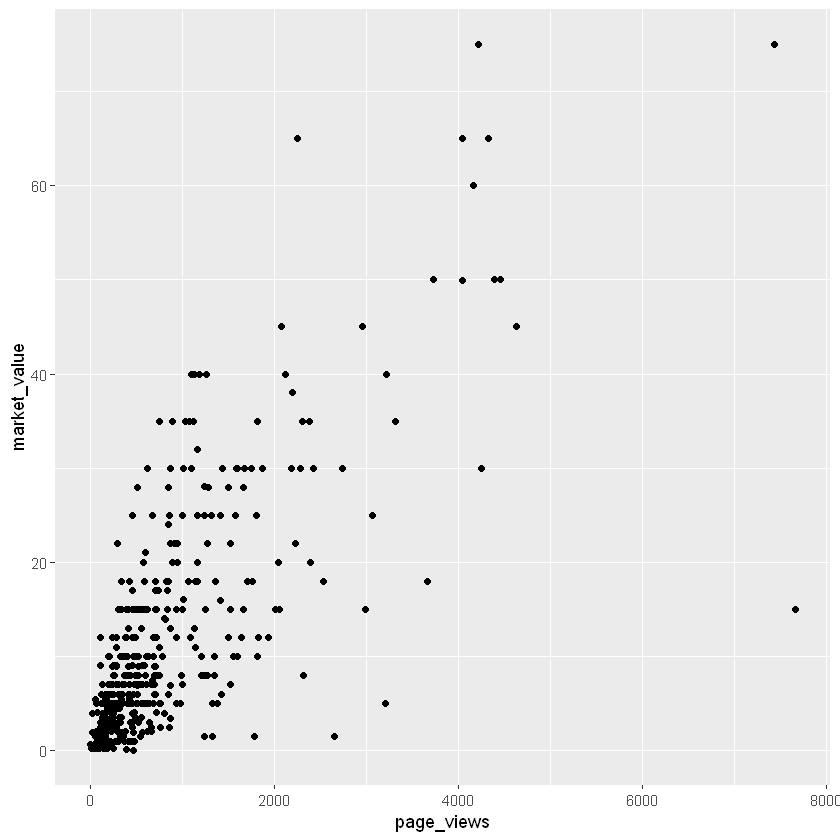

In [11]:
#by page_views
ggplot(epl,aes(y=market_value,x=page_views)) +geom_jitter()
   

See that one dot with close to 8,000 page views and only about 15 for market value...have you seen it? Yeah, that's Wayne Rooney, his overpopularity doesnt seem to relate particularly well with market value so we'll mark that down as a potential banana skin. The other top popular dot is Paul Pogba, if you were wondering.

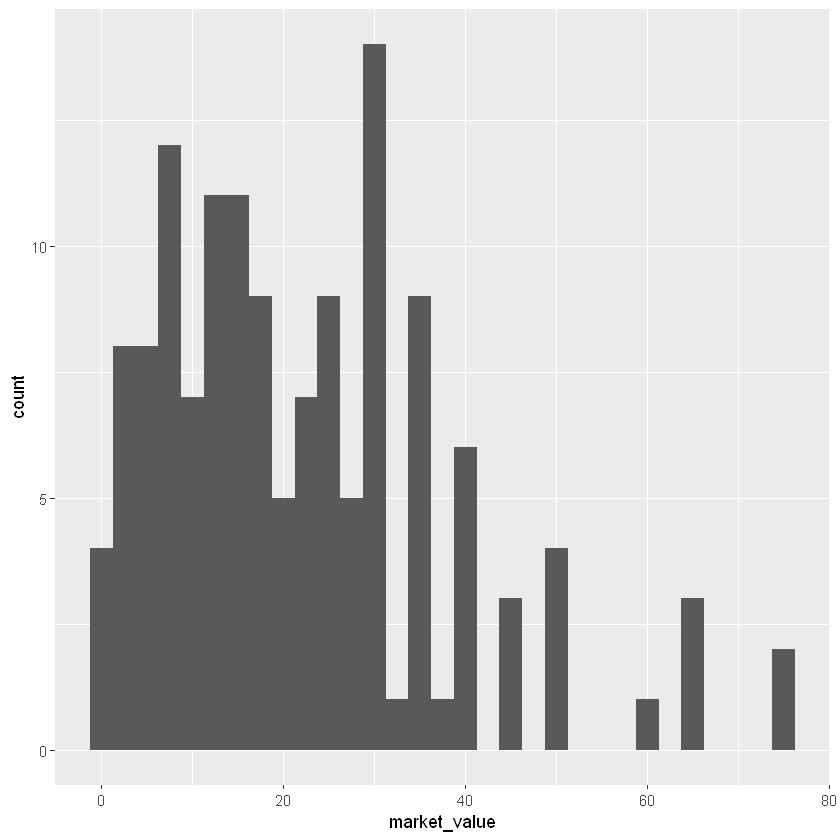

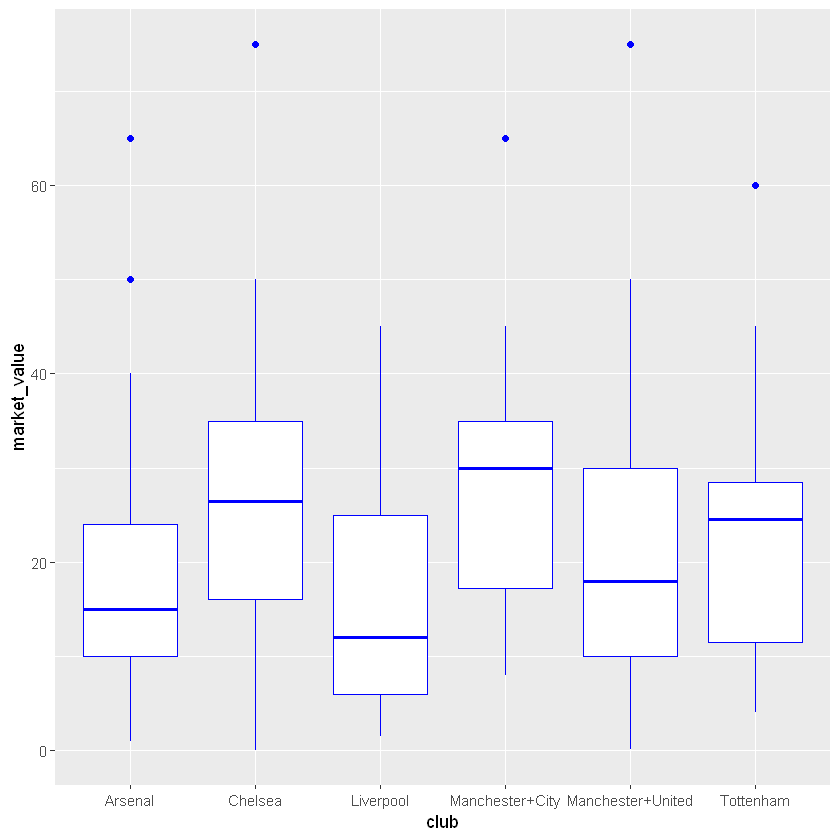

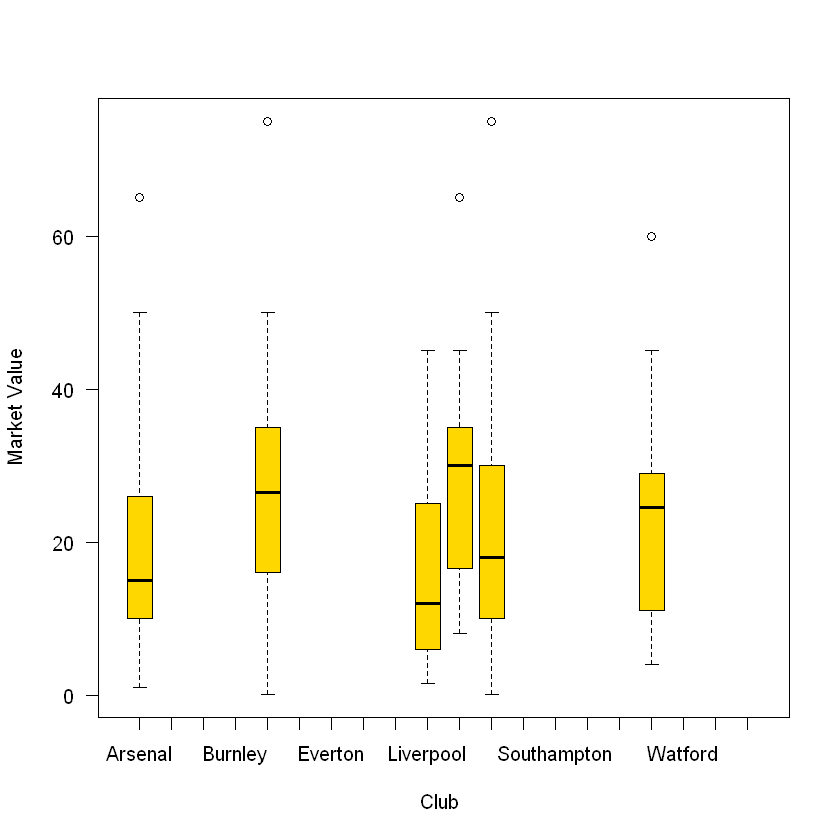

In [12]:
#for the big six clubs
ggplot(big_six,aes(market_value))+geom_histogram(binwidth = 2.5)

ggplot(big_six,aes(y=market_value,x=club)) +geom_boxplot(col = "blue")
with(data=big_six,plot(big_six$club, market_value, 
                   xlab = "Club ", ylab = "Market Value", 
                   col = "gold", las = 1))


Since we are focused on market value, some values might cause skewed predictions of our models like the outlier "wayne rooney" whose astronomical page views doesn't line up with his value (popularity fail I guess). We are going to create a new dataset for our modelling without this outlier value and those of players from the three promoted teams since they had no bearing on the market value from the previous premier league season.

In [13]:
#remove newly promoted clubs and outlier Rooney
epl_new <- subset(epl, !epl$club_id %in% c(3,8,13)) 
epl_new <- subset(epl_new, !epl_new$name %in% c("Wayne Rooney")) #popularity outlier 
epl_new$market_value <- round(epl_new$market_value)

Lets take a look at the new set shall we

In [14]:
head(epl_new, n = 5)

name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
Alexis Sanchez,Arsenal,28,LW,Attacker,65,4329,12.0,17.10%,264,3,Chile,0,29-31,1,1,0
Mesut Ozil,Arsenal,28,AM,Attacker,50,4395,9.5,5.60%,167,2,Germany,0,29-31,1,1,0
Petr Cech,Arsenal,35,GK,GoalKeeper,7,1529,5.5,5.90%,134,2,Czech Republic,0,34-38,1,1,0
Theo Walcott,Arsenal,28,RW,Attacker,20,2393,7.5,1.50%,122,1,England,0,29-31,1,1,0
Laurent Koscielny,Arsenal,31,CB,Defender,22,912,6.0,0.70%,121,2,France,0,29-31,1,1,0


## Now to split our new dataset for modelling into training and test sets
We are gonna do that in 75 - 25 percent split.

In [ ]:
#### split into training and test ####
set.seed(1244) # set seed for repeatability of training-and-test split
training_test <- c(rep(1,length=trunc((2/3)*nrow(epl_new))),
                   rep(2,length=(nrow(epl_new) - trunc((2/3)*nrow(epl_new)))))

epl_new$training_test <- sample(training_test) # random permutation 
epl_new$training_test <- factor(epl_new$training_test,levels=c(1,2), labels=c("TRAIN","TEST"))

eplNew.train <-subset(epl_new, training_test == "TRAIN")
eplNew.test <-subset(epl_new, training_test == "TEST")

print(str(eplNew.train))
print(str(eplNew.test))

## Modelling
We are going to be predicting the market values with two regression models: Linear regression model and then Random forest.
With the linear regression model we first select all the features from our dataset, this will be called "model" based on all the features that had a correlation to market value higher than 0.5 and which region they come from.

In [ ]:
#### Linear Regression ####
#training the model on six features, page views ,fpl value, position, age and whether or not they are in the big six club
model <- lm(market_value ~ page_views + fpl_value + region + position_cat + age_cat + big_club , data = eplNew.train)

Now we try to predict the test set market values, and create a new data set to see how well our model performed. Comparing the test set market values with the ones our model predicted.  

In [18]:
eplNew.test$predict_MV <- round(predict(model, newdata = eplNew.test)) ### model prediction on the test set ###

In [ ]:
#LR prediction accuraccy
outputNew.test <- eplNew.test[c("name","market_value", "predict_MV")]

outputNew.test$MV <- with(data=outputNew.test,
                                  ifelse ((market_value < 10),1,
                                  ifelse ((market_value < 20),2,
                                  ifelse ((market_value < 30),3,
                                  ifelse ((market_value < 40),4,
                                  ifelse ((market_value < 50),5,6))))))


outputNew.test$pMV <- with(data=outputNew.test,
                                  ifelse ((predict_MV < 10),1,
                                  ifelse ((predict_MV < 20),2,
                                  ifelse ((predict_MV < 30),3,
                                  ifelse ((predict_MV < 40),4,
                                  ifelse ((predict_MV < 50),5,6))))))

tab <- table(outputNew.test$pMV, outputNew.test$MV)
cm <- confusionMatrix(tab)
cm

 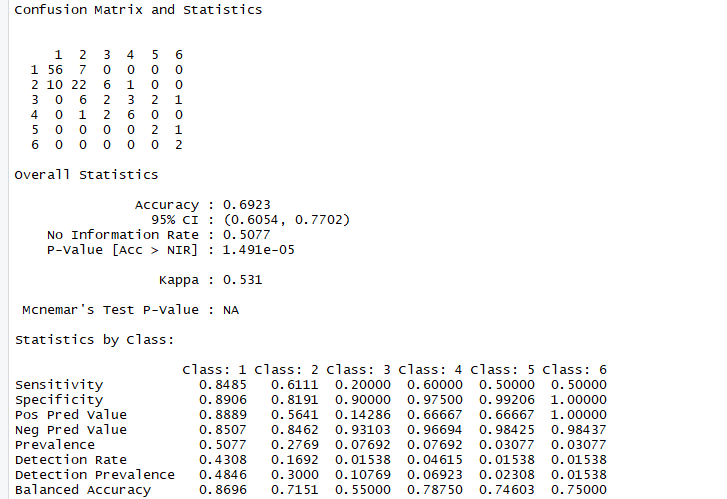
 
Above is the confusion matrix classifying the predicted market value into six groups, from market values below 10 million pounds to those above 50 million pounds. We split the predictions into these groups of 10 to remove the affects of decimals.

As you can see the accurary of getting a prediction in the right class is 0.6923 or 69% which isn't great. Now lets look at the true positive rate (sensitivity) of each class, we are more interested in this metric because we have various classes. Class 1 (those valued under 10 million) has the highest percentage predicted right, not suprising since we have more of these players in the league.
 

In [ ]:
#####Random Forest ####
library(randomForest)
model.rf <- randomForest(market_value ~ page_views + fpl_value + region + position_cat + age_cat + big_club, data = eplNew.train)
yhat.rf <- predict(model.rf, newdata = eplNew.test)
MSE <- mean((yhat.rf - eplNew.test$market_value) ^2) #mean squared error of our Forest.

In [ ]:
importance(model.rf)
plot(model.rf)
varImpPlot(model.rf)
R2 <- RMSE(yhat.rf, eplNew.test$market_value)

In [ ]:
### RF Accuracy
outputNew.test$rfpred_MV <- round(yhat.rf)

outputNew.test$rfMV <- with(data=outputNew.test,
                           ifelse ((rfpred_MV < 10),1,
                           ifelse ((rfpred_MV < 20),2,
                           ifelse ((rfpred_MV < 30),3,
                           ifelse ((rfpred_MV < 40),4,
                           ifelse ((rfpred_MV < 50),5,6))))))

rftab <- table(outputNew.test$rfMV, outputNew.test$MV)
rfcm <- confusionMatrix(rftab)
rfcm


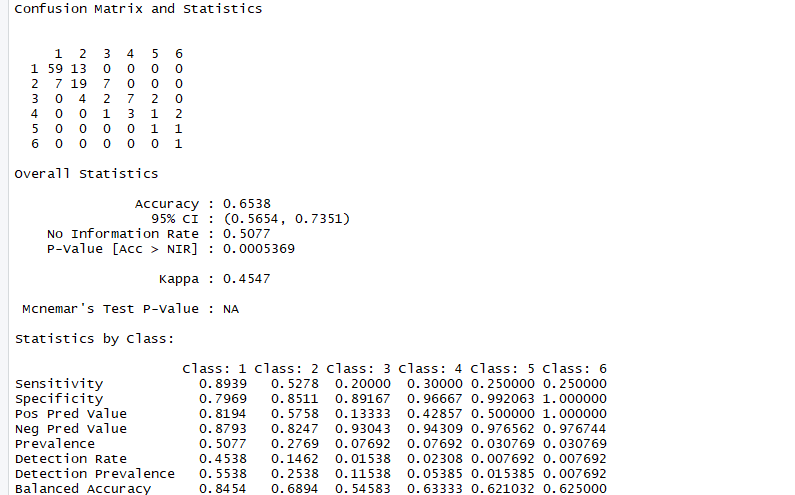

Again we have a similar accuracy rating of 0.6538, again we look at sensitivity and again those less than 10 million in value are predicted truely at a higher rate. If we compare the two methods used, there isn't much of a difference in the accurary of each model, Linear Regression in this case is slightly more accurate thatn random forest.
And that concludes this project '')